In [1430]:
from numpy.random import uniform
from numpy import multiply
import numpy as np
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import random
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
%matplotlib inline

In [1431]:
#the terrain function and initial CA parameters
#CA dimensions:
dimx=100 
dimy=100
treedens=0.9 #tree density
#elevation ranges for synthetic DEM:
low_elevation = 100
high_elevation = 2500
sigma=5 #terrain smoothness
#controls for the assumption that the wildfire 
#starts in the lower 30% of the elevation range of the DEM:
fire_start_elev_threshold=0.75
#from all trees in these lower regions, this rate controls the probability of ignition (2%):
low_tree_ignition_rate=0.02

In [1432]:
#the synthetic DEM creation function:
def fake_surface(low, high, sigma, dim):
    '''Super basic random terrain function.
    
    This function generates a uniform random surface,
    and applies a sequence (x and y) of one-dimensional
    convolution filters; effectively increasing the spatial
    autocorrelation of the surface relative to sigma.
    
    Paramters
    ---------
    dim : tuple
        The x and y dimensions of the 'terrain' grid.
    low : numeric
        The lowest possible simulated elevation value.
    high : numeric
        The highest possible simulated elevation value.
    sigma : numeric
        The variance of the gaussian kernel. Controls
        the 'smoothness' of the simulated surface.
        Values between 1 and 3 are probably good for
        'small' surfaces.
        
    Returns
    -------
    out : ndarray
        A spatially autocorrelated random 'terrain' surface
        of a given dimension.
    '''
    r = uniform(low, high, size=multiply(*dim)).reshape(dim)
    return gaussian_filter(r, sigma=sigma, truncate=9)

In [1433]:
#the wild fire CA definition:
class TreeCell(Agent): # object
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        #super().__init__(pos, model)
        Agent.__init__(self, pos, model) #I had to change the previous line to this to make it work.
        
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        
        self.elevation = model.dem[pos[1]][pos[0]] #get the elevation of the tree object, store it as attribute.
        #print self.elevation 
        
    def step(self):
        '''
        If the tree is on fire, spread it to fine trees nearby.
        Fires travel faster uphill, if the neighbor is uphill, the fire is passed to the neighbour.
        '''
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                #implement terrain dependency here: 
                #we assume fire does not spread downhill,
                #so only if the neighbor is higher than the center cell,
                #the fire spreads to the neighbour:
                if neighbor.condition == "Fine":
                    if neighbor.elevation > self.elevation:
                        neighbor.condition = "On Fire"
            self.condition = "Burned Out"

class ForestFire(Model):
    '''
    Simple Forest Fire model.
    '''
    
    #I define the dem attribute outside of the init function to make it accessible publicly...
    dem = fake_surface(low_elevation,high_elevation,sigma,(dimx,dimy)) #create a dem surface for the model
    
    def __init__(self, height, width, density):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")})
        
        self.grids = list() # empty list to collect the grids of the time steps
        self.dem = self.dem
        
        # Place a tree in each cell with Prob = density
        # also we assume the wildfire to start in the lower regions of the terrain.
        # where elevation < max_ignition_elevation  
        
        elev_range = np.max(self.dem) - np.min(self.dem)
        max_ignition_elevation = np.min(self.dem)+fire_start_elev_threshold*elev_range
        
        for x in range(self.width):
            for y in range(self.height):                
                if random.random() < self.density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    # Set all trees in the first and last column and row on fire.
                    #if x in (1,self.width-1) or y in (1,self.height-1):  
                    #if tree is lower than max_ignition_elevation, set on fire
                    if self.dem[y][x] < max_ignition_elevation:
                        if random.random() < low_tree_ignition_rate:
                            new_tree.condition = "On Fire"
                    self.grid[y][x] = new_tree
                    #print new_tree.elevation
                    self.schedule.add(new_tree)
        self.running = True

    #adding method to collect the grid at a timestep:
    
    def fetch_grid(self):
        #create a numpy array with the cell states converted as integers for each time step
        cell_conditions=np.zeros((self.height,self.width)) 
        for tree in self.schedule.agents:
            (currx,curry) = tree.pos
            if tree.condition == "Fine":
                cell_conditions[curry][currx] = 3
            if tree.condition == "On Fire":
                cell_conditions[curry][currx] = 2
            if tree.condition == "Burned Out":
                cell_conditions[curry][currx] = 1     
    
        self.grids.append(cell_conditions)

  
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        self.fetch_grid()
        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
        
        
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count    

In [1434]:
#run the model:
fire = ForestFire(dimx, dimy, treedens)
fire.run_model()

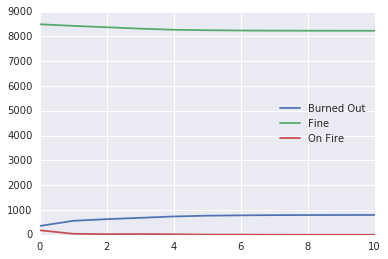

In [1435]:
#visualize results:
results = fire.dc.get_model_vars_dataframe()
results.plot()

Wildfire state in step 1


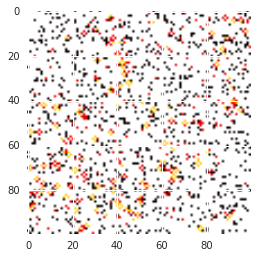

Wildfire state in step 2


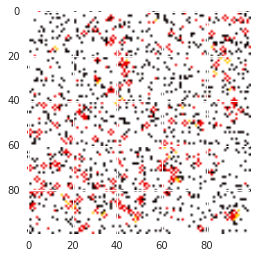

Wildfire state in step 3


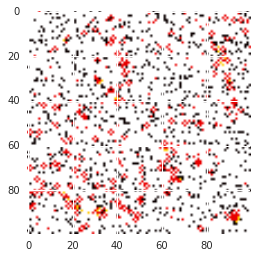

Wildfire state in step 4


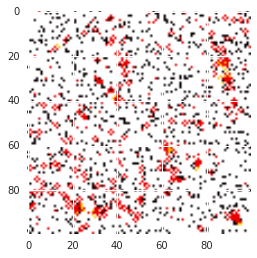

Wildfire state in step 5


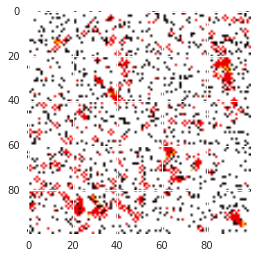

Wildfire state in step 6


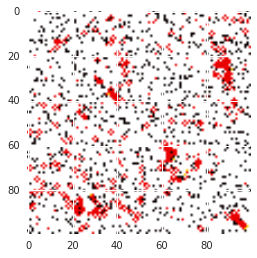

Wildfire state in step 7


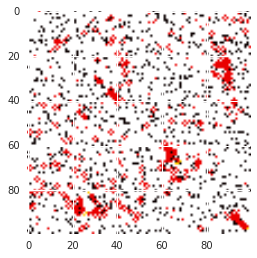

Wildfire state in step 8


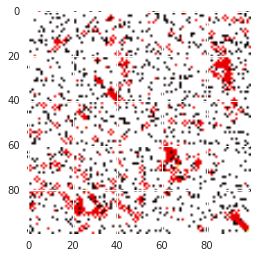

Wildfire state in step 9


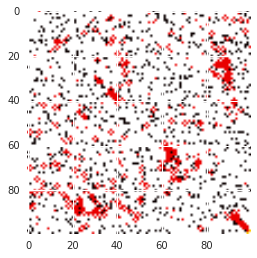

Wildfire state in step 10


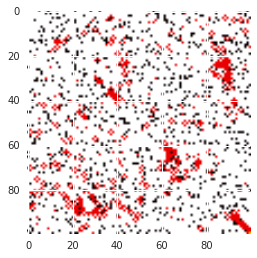

Wildfire state in step 11


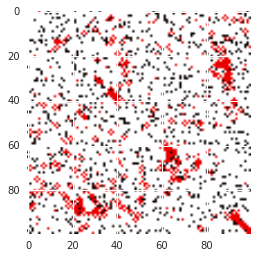

In [1436]:
# visualize cell states for the time steps:
visualize_frequency = 1#plot every n step
count=0
for current_grid in fire.grids:
    count+=1
    if count%visualize_frequency==0: #for each step to be visualised:

        print "Wildfire state in step %s" % str(count)       
        plt.imshow(current_grid,cmap=plt.get_cmap("hot"))
        plt.show()


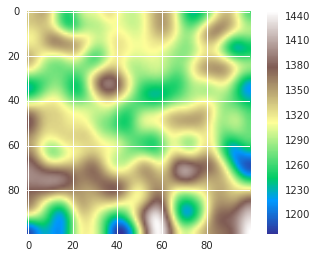

In [1437]:
plt.imshow(ForestFire.dem, cmap=plt.get_cmap("terrain"))
plt.colorbar()
plt.show()